# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 3, #degree
        'n': 4, #number of variables
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0,
        'a_max': 10,
        'a_min': -10,
        'polynomial_data_size': 100,
        'lambda_nets_total': 100,
        'noise': 0,
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
        
    },
    'lambda_net': {
        'epochs_lambda': 200,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 1000,
    },    
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 20,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
    
        'random_evaluation_dataset_size': 500,
    },    
    'computation':{
        'n_jobs': -3,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *

from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys
import os

import shutil

import logging
logging.getLogger('tensorflow').disabled = True

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import tensorflow as tf
import random 


import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n] 

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda

if same_training_all_lambda_nets:
    training_string = '_same'
else:
    training_string = '_diverse'
    
    
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [5]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda


config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])

config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']
    
transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

initialize_utility_functions_config_from_curent_notebook(config)
initialize_LambdaNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(inet=False))
generate_directory_structure()
generate_lambda_net_directory()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

<class 'KeyError'>
<class 'KeyError'>


In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


In [7]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


  0%|          | 0/256 [00:00<?, ?it/s]

List length: 256
Number of monomials in a polynomial with 4 variables and degree 3: 35
Sparsity: 35
['0000', '0001', '0002', '0003', '0010', '0011', '0012', '0013', '0020', '0021', '0022', '0023', '0030', '0031', '0032', '0033', '0100', '0101', '0102', '0103', '0110', '0111', '0112', '0113', '0120', '0121', '0122', '0123', '0130', '0131', '0132', '0133', '0200', '0201', '0202', '0203', '0210', '0211', '0212', '0213', '0220', '0221', '0222', '0223', '0230', '0231', '0232', '0233', '0300', '0301', '0302', '0303', '0310', '0311', '0312', '0313', '0320', '0321', '0322', '0323', '0330', '0331', '0332', '0333', '1000', '1001', '1002', '1003', '1010', '1011', '1012', '1013', '1020', '1021', '1022', '1023', '1030', '1031', '1032', '1033', '1100', '1101', '1102', '1103', '1110', '1111', '1112', '1113', '1120', '1121', '1122', '1123', '1130', '1131', '1132', '1133', '1200', '1201', '1202', '1203', '1210', '1211', '1212', '1213', '1220', '1221', '1222', '1223', '1230', '1231', '1232', '1233', '13

  0%|          | 0/256 [00:00<?, ?it/s]

List length: 35
Number of monomials in a polynomial with 4 variables and degree 3: 35
Sparsity: 35
['0000', '0001', '0002', '0003', '0010', '0011', '0012', '0020', '0021', '0030', '0100', '0101', '0102', '0110', '0111', '0120', '0200', '0201', '0210', '0300', '1000', '1001', '1002', '1010', '1011', '1020', '1100', '1101', '1110', '1200', '2000', '2001', '2010', '2100', '3000']


In [8]:
path_polynomials = './data/saved_polynomial_lists/polynomials_sample' + str(polynomial_data_size) + '_variables_' + str(n) +  '_degree_' + str(d) + '_sparsity_' + str(sample_sparsity) + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '.csv'
polynomials_list_df = pd.read_csv(path_polynomials)

path_X_data = './data/saved_polynomial_lists/X_sample' + str(polynomial_data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sample_sparsity)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + '_noise_' + str(noise) +  training_string + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_polynomial_lists/y_sample' + str(polynomial_data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sample_sparsity)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + '_noise_' + str(noise) +  training_string + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
if lambda_nets_total < polynomial_data_size:
    polynomials_list_df = polynomials_list_df.sample(n=lambda_nets_total, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, lambda_nets_total)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, lambda_nets_total)
    random.seed(RANDOM_SEED)

## Data Inspection

In [9]:
X_data_list[0][1].head()

,a,b,c,d
0,0.375,0.185,0.262,0.673
1,0.951,0.542,0.247,0.797
2,0.732,0.873,0.906,0.250
3,0.599,0.732,0.250,0.625
4,0.156,0.807,0.272,0.572


In [10]:
X_data_list[1][1].head()

,a,b,c,d
0,0.115,0.520,0.909,0.996
1,0.609,0.116,0.421,0.636
2,0.133,0.852,0.519,0.832
3,0.241,0.035,0.150,0.282
4,0.327,0.447,0.014,0.108


In [11]:
X_data_list[0][0].head()

0000   -2.509
0001    9.014
0002    4.640
0003    1.973
0010   -6.880
dtype: float64

In [12]:
X_data_list[1][0].head()

0000    6.168
0001   -3.908
0002   -8.047
0003    3.685
0010   -1.197
dtype: float64

## Lambda Network Training + Weigh/Bias saving

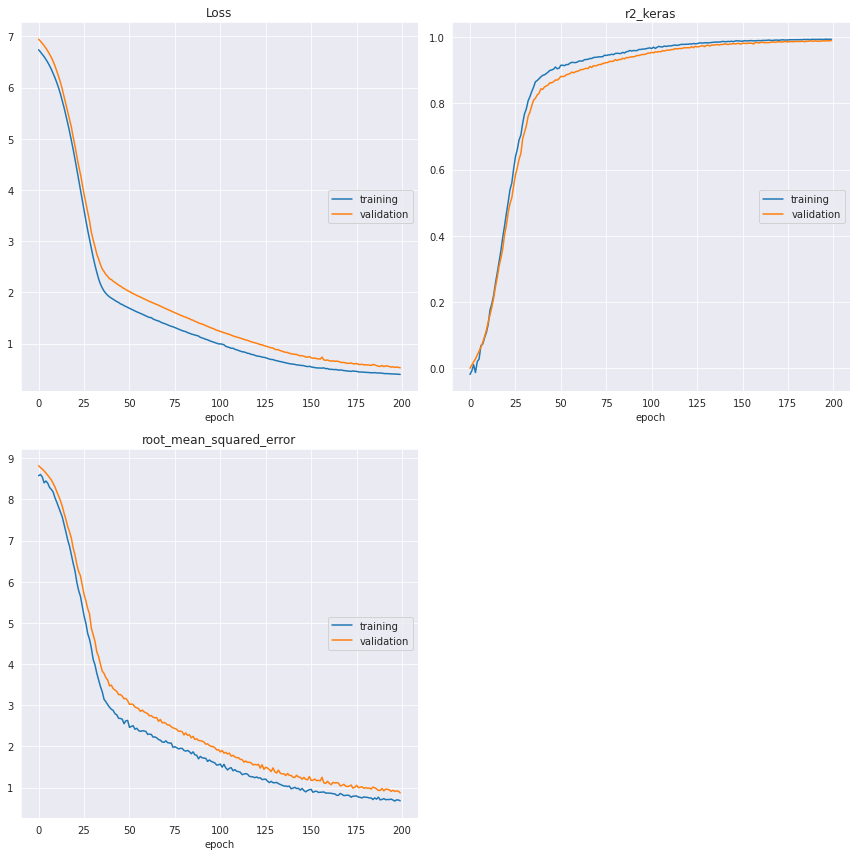

Loss
	training         	 (min:    0.399, max:    6.738, cur:    0.399)
	validation       	 (min:    0.529, max:    6.944, cur:    0.529)
r2_keras
	training         	 (min:   -0.018, max:    0.994, cur:    0.993)
	validation       	 (min:    0.001, max:    0.990, cur:    0.990)
root_mean_squared_error
	training         	 (min:    0.672, max:    8.608, cur:    0.679)
	validation       	 (min:    0.871, max:    8.819, cur:    0.871)


In [13]:
clf_list = []
chunksize = 5000 if lambda_nets_total > 50000 else max(lambda_nets_total//10, min(50, lambda_nets_total))
X_data_list_splits = list(chunks(X_data_list, chunksize))
y_data_list_splits = list(chunks(y_data_list, chunksize))

max_seed = 2147483646
seed_list = random.sample(range(0, max_seed), number_different_lambda_trainings)
chunk_multiplier = 0

for X_data_list_split, y_data_list_split in tqdm(zip(X_data_list_splits, y_data_list_splits), total=max(len(X_data_list_splits), len(y_data_list_splits))):
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    clf_sublist = parallel(delayed(train_nn)(chunksize*chunk_multiplier+index, X_data[1].values, y_data[1].values, X_data[0], seed_list, return_history=True, each_epochs_save=each_epochs_save_lambda, printing=True) for index, (X_data, y_data) in enumerate(zip(X_data_list_split, y_data_list_split)))  
    clf_list.extend(clf_sublist)
    del parallel
    chunk_multiplier +=1
rand_index = np.random.randint(lambda_nets_total)
random_network = train_nn(rand_index, X_data_list[rand_index][1], y_data_list[rand_index][1], X_data_list[rand_index][0], seed_list, callbacks=[PlotLossesKerasTF()], return_model=True)


## Save and Plot Lambda-Model History

In [16]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

for _, entry in tqdm(enumerate(clf_list)):
    entry = entry[3]
    loss_list = []
    metric_list = []
    val_loss_list = []
    val_metric_list = []
    for i in range(epochs_lambda):  
        loss_list.append(entry['loss'][i])
        metric_list.append(entry['r2_keras'][i])
        val_loss_list.append(entry['val_loss'][i])
        val_metric_list.append(entry['val_r2_keras'][i])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=loss_list_total, columns=['loss_epoch_' + str(i+1) for i in range(epochs_lambda)])
metric_df = pd.DataFrame(data=metric_list_total, columns=['metric_epoch_' + str(i+1) for i in range(epochs_lambda)]) 
val_loss_df = pd.DataFrame(data=val_loss_list_total, columns=['val_loss_epoch_' + str(i+1) for i in range(epochs_lambda)])
val_metric_df = pd.DataFrame(data=val_metric_list_total, columns=['val_metric_epoch_' + str(i+1) for i in range(epochs_lambda)]) 


0it [00:00, ?it/s]

In [19]:
path_loss = './data/weights/weights_' + str(lambda_nets_total) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_loss_' + str(lambda_nets_total) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
path_metric = './data/weights/weights_' + str(lambda_nets_total) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_metric_' + str(lambda_nets_total) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
path_val_loss = './data/weights/weights_' + str(lambda_nets_total) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_val_loss_' + str(lambda_nets_total) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
path_val_metric = './data/weights/weights_' + str(lambda_nets_total) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_val_metric_' + str(lambda_nets_total) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [20]:
loss_df.describe()

,loss_epoch_1,loss_epoch_2,loss_epoch_3,loss_epoch_4,loss_epoch_5,loss_epoch_6,loss_epoch_7,loss_epoch_8,loss_epoch_9,loss_epoch_10,loss_epoch_11,loss_epoch_12,loss_epoch_13,loss_epoch_14,loss_epoch_15,loss_epoch_16,loss_epoch_17,loss_epoch_18,loss_epoch_19,loss_epoch_20,loss_epoch_21,loss_epoch_22,loss_epoch_23,loss_epoch_24,loss_epoch_25,loss_epoch_26,loss_epoch_27,loss_epoch_28,loss_epoch_29,loss_epoch_30,loss_epoch_31,loss_epoch_32,loss_epoch_33,loss_epoch_34,loss_epoch_35,loss_epoch_36,loss_epoch_37,loss_epoch_38,loss_epoch_39,loss_epoch_40,loss_epoch_41,loss_epoch_42,loss_epoch_43,loss_epoch_44,loss_epoch_45,loss_epoch_46,loss_epoch_47,loss_epoch_48,loss_epoch_49,loss_epoch_50,loss_epoch_51,loss_epoch_52,loss_epoch_53,loss_epoch_54,loss_epoch_55,loss_epoch_56,loss_epoch_57,loss_epoch_58,loss_epoch_59,loss_epoch_60,loss_epoch_61,loss_epoch_62,loss_epoch_63,loss_epoch_64,loss_epoch_65,loss_epoch_66,loss_epoch_67,loss_epoch_68,loss_epoch_69,loss_epoch_70,loss_epoch_71,loss_epoch_72,loss_epoch_73,loss_epoch_74,loss_epoch_75,loss_epoch_76,loss_epoch_77,loss_epoch_78,loss_epoch_79,loss_epoch_80,loss_epoch_81,loss_epoch_82,loss_epoch_83,loss_epoch_84,loss_epoch_85,loss_epoch_86,loss_epoch_87,loss_epoch_88,loss_epoch_89,loss_epoch_90,loss_epoch_91,loss_epoch_92,loss_epoch_93,loss_epoch_94,loss_epoch_95,loss_epoch_96,loss_epoch_97,loss_epoch_98,loss_epoch_99,loss_epoch_100,loss_epoch_101,loss_epoch_102,loss_epoch_103,loss_epoch_104,loss_epoch_105,loss_epoch_106,loss_epoch_107,loss_epoch_108,loss_epoch_109,loss_epoch_110,loss_epoch_111,loss_epoch_112,loss_epoch_113,loss_epoch_114,loss_epoch_115,loss_epoch_116,loss_epoch_117,loss_epoch_118,loss_epoch_119,loss_epoch_120,loss_epoch_121,loss_epoch_122,loss_epoch_123,loss_epoch_124,loss_epoch_125,loss_epoch_126,loss_epoch_127,loss_epoch_128,loss_epoch_129,loss_epoch_130,loss_epoch_131,loss_epoch_132,loss_epoch_133,loss_epoch_134,loss_epoch_135,loss_epoch_136,loss_epoch_137,loss_epoch_138,loss_epoch_139,loss_epoch_140,loss_epoch_141,loss_epoch_142,loss_epoch_143,loss_epoch_144,loss_epoch_145,loss_epoch_146,loss_epoch_147,loss_epoch_148,loss_epoch_149,loss_epoch_150,loss_epoch_151,loss_epoch_152,loss_epoch_153,loss_epoch_154,loss_epoch_155,loss_epoch_156,loss_epoch_157,loss_epoch_158,loss_epoch_159,loss_epoch_160,loss_epoch_161,loss_epoch_162,loss_epoch_163,loss_epoch_164,loss_epoch_165,loss_epoch_166,loss_epoch_167,loss_epoch_168,loss_epoch_169,loss_epoch_170,loss_epoch_171,loss_epoch_172,loss_epoch_173,loss_epoch_174,loss_epoch_175,loss_epoch_176,loss_epoch_177,loss_epoch_178,loss_epoch_179,loss_epoch_180,loss_epoch_181,loss_epoch_182,loss_epoch_183,loss_epoch_184,loss_epoch_185,loss_epoch_186,loss_epoch_187,loss_epoch_188,loss_epoch_189,loss_epoch_190,loss_epoch_191,loss_epoch_192,loss_epoch_193,loss_epoch_194,loss_epoch_195,loss_epoch_196,loss_epoch_197,loss_epoch_198,loss_epoch_199,loss_epoch_200
count,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.0

In [21]:
val_loss_df.describe()

,val_loss_epoch_1,val_loss_epoch_2,val_loss_epoch_3,val_loss_epoch_4,val_loss_epoch_5,val_loss_epoch_6,val_loss_epoch_7,val_loss_epoch_8,val_loss_epoch_9,val_loss_epoch_10,val_loss_epoch_11,val_loss_epoch_12,val_loss_epoch_13,val_loss_epoch_14,val_loss_epoch_15,val_loss_epoch_16,val_loss_epoch_17,val_loss_epoch_18,val_loss_epoch_19,val_loss_epoch_20,val_loss_epoch_21,val_loss_epoch_22,val_loss_epoch_23,val_loss_epoch_24,val_loss_epoch_25,val_loss_epoch_26,val_loss_epoch_27,val_loss_epoch_28,val_loss_epoch_29,val_loss_epoch_30,val_loss_epoch_31,val_loss_epoch_32,val_loss_epoch_33,val_loss_epoch_34,val_loss_epoch_35,val_loss_epoch_36,val_loss_epoch_37,val_loss_epoch_38,val_loss_epoch_39,val_loss_epoch_40,val_loss_epoch_41,val_loss_epoch_42,val_loss_epoch_43,val_loss_epoch_44,val_loss_epoch_45,val_loss_epoch_46,val_loss_epoch_47,val_loss_epoch_48,val_loss_epoch_49,val_loss_epoch_50,val_loss_epoch_51,val_loss_epoch_52,val_loss_epoch_53,val_loss_epoch_54,val_loss_epoch_55,val_loss_epoch_56,val_loss_epoch_57,val_loss_epoch_58,val_loss_epoch_59,val_loss_epoch_60,val_loss_epoch_61,val_loss_epoch_62,val_loss_epoch_63,val_loss_epoch_64,val_loss_epoch_65,val_loss_epoch_66,val_loss_epoch_67,val_loss_epoch_68,val_loss_epoch_69,val_loss_epoch_70,val_loss_epoch_71,val_loss_epoch_72,val_loss_epoch_73,val_loss_epoch_74,val_loss_epoch_75,val_loss_epoch_76,val_loss_epoch_77,val_loss_epoch_78,val_loss_epoch_79,val_loss_epoch_80,val_loss_epoch_81,val_loss_epoch_82,val_loss_epoch_83,val_loss_epoch_84,val_loss_epoch_85,val_loss_epoch_86,val_loss_epoch_87,val_loss_epoch_88,val_loss_epoch_89,val_loss_epoch_90,val_loss_epoch_91,val_loss_epoch_92,val_loss_epoch_93,val_loss_epoch_94,val_loss_epoch_95,val_loss_epoch_96,val_loss_epoch_97,val_loss_epoch_98,val_loss_epoch_99,val_loss_epoch_100,val_loss_epoch_101,val_loss_epoch_102,val_loss_epoch_103,val_loss_epoch_104,val_loss_epoch_105,val_loss_epoch_106,val_loss_epoch_107,val_loss_epoch_108,val_loss_epoch_109,val_loss_epoch_110,val_loss_epoch_111,val_loss_epoch_112,val_loss_epoch_113,val_loss_epoch_114,val_loss_epoch_115,val_loss_epoch_116,val_loss_epoch_117,val_loss_epoch_118,val_loss_epoch_119,val_loss_epoch_120,val_loss_epoch_121,val_loss_epoch_122,val_loss_epoch_123,val_loss_epoch_124,val_loss_epoch_125,val_loss_epoch_126,val_loss_epoch_127,val_loss_epoch_128,val_loss_epoch_129,val_loss_epoch_130,val_loss_epoch_131,val_loss_epoch_132,val_loss_epoch_133,val_loss_epoch_134,val_loss_epoch_135,val_loss_epoch_136,val_loss_epoch_137,val_loss_epoch_138,val_loss_epoch_139,val_loss_epoch_140,val_loss_epoch_141,val_loss_epoch_142,val_loss_epoch_143,val_loss_epoch_144,val_loss_epoch_145,val_loss_epoch_146,val_loss_epoch_147,val_loss_epoch_148,val_loss_epoch_149,val_loss_epoch_150,val_loss_epoch_151,val_loss_epoch_152,val_loss_epoch_153,val_loss_epoch_154,val_loss_epoch_155,val_loss_epoch_156,val_loss_epoch_157,val_loss_epoch_158,val_loss_epoch_159,val_loss_epoch_160,val_loss_epoch_161,val_loss_epoch_162,val_loss_epoch_163,val_loss_epoch_164,val_loss_epoch_165,val_loss_epoch_166,val_loss_epoch_167,val_loss_epoch_168,val_loss_epoch_169,val_loss_epoch_170,val_loss_epoch_171,val_loss_epoch_172,val_loss_epoch_173,val_loss_epoch_174,val_loss_epoch_175,val_loss_epoch_176,val_loss_epoch_177,val_loss_epoch_178,val_loss_epoch_179,val_loss_epoch_180,val_loss_epoch_181,val_loss_epoch_182,val_loss_epoch_183,val_loss_epoch_184,val_loss_epoch_185,val_loss_epoch_186,val_loss_epoch_187,val_loss_epoch_188,val_loss_epoch_189,val_loss_epoch_190,val_loss_epoch_191,val_loss_epoch_192,val_loss_epoch_193,val_loss_epoch_194,val_loss_epoch_195,val_loss_epoch_196,val_loss_epoch_197,val_loss_epoch_198,val_loss_epoch_199,val_loss_epoch_200
count,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.0

In [22]:
metric_df.describe()

,metric_epoch_1,metric_epoch_2,metric_epoch_3,metric_epoch_4,metric_epoch_5,metric_epoch_6,metric_epoch_7,metric_epoch_8,metric_epoch_9,metric_epoch_10,metric_epoch_11,metric_epoch_12,metric_epoch_13,metric_epoch_14,metric_epoch_15,metric_epoch_16,metric_epoch_17,metric_epoch_18,metric_epoch_19,metric_epoch_20,metric_epoch_21,metric_epoch_22,metric_epoch_23,metric_epoch_24,metric_epoch_25,metric_epoch_26,metric_epoch_27,metric_epoch_28,metric_epoch_29,metric_epoch_30,metric_epoch_31,metric_epoch_32,metric_epoch_33,metric_epoch_34,metric_epoch_35,metric_epoch_36,metric_epoch_37,metric_epoch_38,metric_epoch_39,metric_epoch_40,metric_epoch_41,metric_epoch_42,metric_epoch_43,metric_epoch_44,metric_epoch_45,metric_epoch_46,metric_epoch_47,metric_epoch_48,metric_epoch_49,metric_epoch_50,metric_epoch_51,metric_epoch_52,metric_epoch_53,metric_epoch_54,metric_epoch_55,metric_epoch_56,metric_epoch_57,metric_epoch_58,metric_epoch_59,metric_epoch_60,metric_epoch_61,metric_epoch_62,metric_epoch_63,metric_epoch_64,metric_epoch_65,metric_epoch_66,metric_epoch_67,metric_epoch_68,metric_epoch_69,metric_epoch_70,metric_epoch_71,metric_epoch_72,metric_epoch_73,metric_epoch_74,metric_epoch_75,metric_epoch_76,metric_epoch_77,metric_epoch_78,metric_epoch_79,metric_epoch_80,metric_epoch_81,metric_epoch_82,metric_epoch_83,metric_epoch_84,metric_epoch_85,metric_epoch_86,metric_epoch_87,metric_epoch_88,metric_epoch_89,metric_epoch_90,metric_epoch_91,metric_epoch_92,metric_epoch_93,metric_epoch_94,metric_epoch_95,metric_epoch_96,metric_epoch_97,metric_epoch_98,metric_epoch_99,metric_epoch_100,metric_epoch_101,metric_epoch_102,metric_epoch_103,metric_epoch_104,metric_epoch_105,metric_epoch_106,metric_epoch_107,metric_epoch_108,metric_epoch_109,metric_epoch_110,metric_epoch_111,metric_epoch_112,metric_epoch_113,metric_epoch_114,metric_epoch_115,metric_epoch_116,metric_epoch_117,metric_epoch_118,metric_epoch_119,metric_epoch_120,metric_epoch_121,metric_epoch_122,metric_epoch_123,metric_epoch_124,metric_epoch_125,metric_epoch_126,metric_epoch_127,metric_epoch_128,metric_epoch_129,metric_epoch_130,metric_epoch_131,metric_epoch_132,metric_epoch_133,metric_epoch_134,metric_epoch_135,metric_epoch_136,metric_epoch_137,metric_epoch_138,metric_epoch_139,metric_epoch_140,metric_epoch_141,metric_epoch_142,metric_epoch_143,metric_epoch_144,metric_epoch_145,metric_epoch_146,metric_epoch_147,metric_epoch_148,metric_epoch_149,metric_epoch_150,metric_epoch_151,metric_epoch_152,metric_epoch_153,metric_epoch_154,metric_epoch_155,metric_epoch_156,metric_epoch_157,metric_epoch_158,metric_epoch_159,metric_epoch_160,metric_epoch_161,metric_epoch_162,metric_epoch_163,metric_epoch_164,metric_epoch_165,metric_epoch_166,metric_epoch_167,metric_epoch_168,metric_epoch_169,metric_epoch_170,metric_epoch_171,metric_epoch_172,metric_epoch_173,metric_epoch_174,metric_epoch_175,metric_epoch_176,metric_epoch_177,metric_epoch_178,metric_epoch_179,metric_epoch_180,metric_epoch_181,metric_epoch_182,metric_epoch_183,metric_epoch_184,metric_epoch_185,metric_epoch_186,metric_epoch_187,metric_epoch_188,metric_epoch_189,metric_epoch_190,metric_epoch_191,metric_epoch_192,metric_epoch_193,metric_epoch_194,metric_epoch_195,metric_epoch_196,metric_epoch_197,metric_epoch_198,metric_epoch_199,metric_epoch_200
count,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.0

In [23]:
val_metric_df.describe()

,val_metric_epoch_1,val_metric_epoch_2,val_metric_epoch_3,val_metric_epoch_4,val_metric_epoch_5,val_metric_epoch_6,val_metric_epoch_7,val_metric_epoch_8,val_metric_epoch_9,val_metric_epoch_10,val_metric_epoch_11,val_metric_epoch_12,val_metric_epoch_13,val_metric_epoch_14,val_metric_epoch_15,val_metric_epoch_16,val_metric_epoch_17,val_metric_epoch_18,val_metric_epoch_19,val_metric_epoch_20,val_metric_epoch_21,val_metric_epoch_22,val_metric_epoch_23,val_metric_epoch_24,val_metric_epoch_25,val_metric_epoch_26,val_metric_epoch_27,val_metric_epoch_28,val_metric_epoch_29,val_metric_epoch_30,val_metric_epoch_31,val_metric_epoch_32,val_metric_epoch_33,val_metric_epoch_34,val_metric_epoch_35,val_metric_epoch_36,val_metric_epoch_37,val_metric_epoch_38,val_metric_epoch_39,val_metric_epoch_40,val_metric_epoch_41,val_metric_epoch_42,val_metric_epoch_43,val_metric_epoch_44,val_metric_epoch_45,val_metric_epoch_46,val_metric_epoch_47,val_metric_epoch_48,val_metric_epoch_49,val_metric_epoch_50,val_metric_epoch_51,val_metric_epoch_52,val_metric_epoch_53,val_metric_epoch_54,val_metric_epoch_55,val_metric_epoch_56,val_metric_epoch_57,val_metric_epoch_58,val_metric_epoch_59,val_metric_epoch_60,val_metric_epoch_61,val_metric_epoch_62,val_metric_epoch_63,val_metric_epoch_64,val_metric_epoch_65,val_metric_epoch_66,val_metric_epoch_67,val_metric_epoch_68,val_metric_epoch_69,val_metric_epoch_70,val_metric_epoch_71,val_metric_epoch_72,val_metric_epoch_73,val_metric_epoch_74,val_metric_epoch_75,val_metric_epoch_76,val_metric_epoch_77,val_metric_epoch_78,val_metric_epoch_79,val_metric_epoch_80,val_metric_epoch_81,val_metric_epoch_82,val_metric_epoch_83,val_metric_epoch_84,val_metric_epoch_85,val_metric_epoch_86,val_metric_epoch_87,val_metric_epoch_88,val_metric_epoch_89,val_metric_epoch_90,val_metric_epoch_91,val_metric_epoch_92,val_metric_epoch_93,val_metric_epoch_94,val_metric_epoch_95,val_metric_epoch_96,val_metric_epoch_97,val_metric_epoch_98,val_metric_epoch_99,val_metric_epoch_100,val_metric_epoch_101,val_metric_epoch_102,val_metric_epoch_103,val_metric_epoch_104,val_metric_epoch_105,val_metric_epoch_106,val_metric_epoch_107,val_metric_epoch_108,val_metric_epoch_109,val_metric_epoch_110,val_metric_epoch_111,val_metric_epoch_112,val_metric_epoch_113,val_metric_epoch_114,val_metric_epoch_115,val_metric_epoch_116,val_metric_epoch_117,val_metric_epoch_118,val_metric_epoch_119,val_metric_epoch_120,val_metric_epoch_121,val_metric_epoch_122,val_metric_epoch_123,val_metric_epoch_124,val_metric_epoch_125,val_metric_epoch_126,val_metric_epoch_127,val_metric_epoch_128,val_metric_epoch_129,val_metric_epoch_130,val_metric_epoch_131,val_metric_epoch_132,val_metric_epoch_133,val_metric_epoch_134,val_metric_epoch_135,val_metric_epoch_136,val_metric_epoch_137,val_metric_epoch_138,val_metric_epoch_139,val_metric_epoch_140,val_metric_epoch_141,val_metric_epoch_142,val_metric_epoch_143,val_metric_epoch_144,val_metric_epoch_145,val_metric_epoch_146,val_metric_epoch_147,val_metric_epoch_148,val_metric_epoch_149,val_metric_epoch_150,val_metric_epoch_151,val_metric_epoch_152,val_metric_epoch_153,val_metric_epoch_154,val_metric_epoch_155,val_metric_epoch_156,val_metric_epoch_157,val_metric_epoch_158,val_metric_epoch_159,val_metric_epoch_160,val_metric_epoch_161,val_metric_epoch_162,val_metric_epoch_163,val_metric_epoch_164,val_metric_epoch_165,val_metric_epoch_166,val_metric_epoch_167,val_metric_epoch_168,val_metric_epoch_169,val_metric_epoch_170,val_metric_epoch_171,val_metric_epoch_172,val_metric_epoch_173,val_metric_epoch_174,val_metric_epoch_175,val_metric_epoch_176,val_metric_epoch_177,val_metric_epoch_178,val_metric_epoch_179,val_metric_epoch_180,val_metric_epoch_181,val_metric_epoch_182,val_metric_epoch_183,val_metric_epoch_184,val_metric_epoch_185,val_metric_epoch_186,val_metric_epoch_187,val_metric_epoch_188,val_metric_epoch_189,val_metric_epoch_190,val_metric_epoch_191,val_metric_epoch_192,val_metric_epoch_193,val_metric_epoch_194,val_metric_epoch_195,val_metric_e

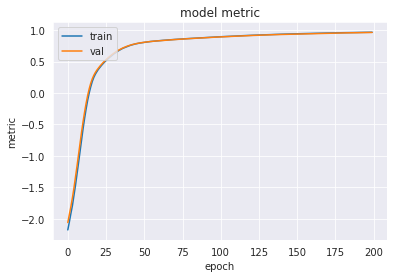

In [28]:
# summarize history for metric
path = './data/results/weights_' + str(lambda_nets_total) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/metric_' + str(lambda_nets_total) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.png'

adjustment_threshold_metric = 0#100
    
metric_df_adjusted = metric_df.copy(deep=True)
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True)
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model metric')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(path)
plt.show()


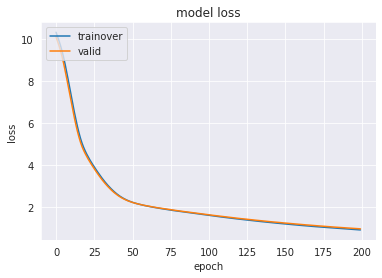

In [26]:
# summarize history for loss
path = './data/results/weights_' + str(lambda_nets_total) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/loss_' + str(lambda_nets_total) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True)

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True)
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['trainover', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()
